In [1]:
import networkx as nx
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score

import numpy as np
import pandas as pd
import pyreadstat
import json
from datetime import datetime

from collections import Counter
import itertools
from scipy.stats import chi2_contingency

from math import comb, ceil
from scipy import stats
import random
import string

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from tqdm import tqdm

import multiprocessing as mp

import pickle

import sys
sys.path.insert(1, '../scripts')
import modeling_v3

import importlib
importlib.reload(modeling_v3)

import matplotlib.ticker as plticker
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 14

import glob

In [13]:
df, meta = pyreadstat.read_dta('../data/gss/GSS_Recoded.dta')

# rename the columns
df.columns = meta.column_labels

# drop duplicate columnstop
df = df.loc[:,~df.columns.duplicated()].copy()

# fill nan values
df = df.fillna('n')

# match explanations with column names
col_name_dict = {e:c for c,e in zip(meta.column_names, meta.column_labels)}

### Variable Values

In [14]:
variable_matching = {meta.column_names_to_labels[k]:v for k,v in meta.variable_value_labels.items()}

Only the unique answers

In [15]:
all_values = [dict(t) for t in {tuple(d.items()) for d in variable_matching.values()}]

only_values = [[*i.values()] for i in all_values]

In [16]:
check = []
unique = {}

for q, m in variable_matching.items():
    set_of_vals = set([*m.values()])
    if set_of_vals not in check:
        check.append(set_of_vals)
        unique[q] = [*m.values()]


In [6]:
with open('../data/gss/vm/unique_variables_list.json', 'w') as f:
    json.dump(unique, f)

ChatGPT answers

In [17]:
with open('../data/gss/vm/variable_matching_chatgpt.json', 'r') as f:
    gpt_matching = json.load(f)

In [18]:
gpt_matching_combined = {}

for d in gpt_matching.values():
    gpt_matching_combined.update(d)

In [19]:
unknowns = ['n', 'NA', 'IAP', 'DK']

for _ in unknowns:
    gpt_matching_combined[_] = "?"

### Match DataFrame Values with variable_matching

In [20]:
variable_matching['should govt reduce income differences'] = {1: 'govt reduce diff',
                                                            2: 'govt reduce diff',
                                                            3: 'govt reduce diff',
                                                            4: 'havent thought much',
                                                            5: 'no govt action',
                                                            6: 'no govt action',
                                                            7: 'no govt action', 'n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['allow anti-religionist to teach', 'allow anti-religionist to teach', 'allow racist to teach', 'allow socialist to teach',
            'should communist teacher be fired', 'allow militarist to teach', 'allow anti-american muslim clergymen teaching in college',
            'allow homosexual to teach',]:
    variable_matching[col] = {1:'allowed', 0:'not allowed', 'n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['bible prayer in public schools']: # not 
    variable_matching[col] = {1:'approve', 2:'disapprove', 3:'NA', 4:'NA', 'n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['should grown children move back with parents']:
    variable_matching[col] = {1: 'a good idea', 2: 'a bad idea', 4: 'it depends', 'n': 'NA', 'd': "Don't know", 'i': 'IAP'}

for col in ['defense spending--rs position']:
    variable_matching[col] = {0: 'havent thought much', 1: 'greatly decrease', 2: 'greatly decrease', 3: 'greatly decrease',
                                4:'havent thought much', 5: 'greatly increase', 6: 'greatly increase', 7: 'greatly increase',
                                'n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['defense spending--rs position', 'help minorities--rs position', 'cut govt spending--rs position']:
    variable_matching[col] = {0: 'havent thought much', 1:'govt help', 2:'govt help', 3:'govt help', 4:'havent thought much',
                            5: 'help selves', 6: 'help selves', 7: 'help selves','n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['family and children', 'career and work', 'free time and relaxation', 'relatives', 'religion and church',
            'politics and public life',]:
    variable_matching[col] = {1:'unimportant', 2:'unimportant', 3:'unimportant', 4:'very important',
                            5: 'very important', 6: 'very important', 7: 'very important','n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['should govt improve standard of living?', 'should govt do more or less?', 'should govt help pay for medical care?',
            'should govt aid blacks?',]:
    variable_matching[col] = {1:'govt action', 2:'govt action', 3:'agree with both', 4:'people help selves',
                            5: 'people help selves', 'n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['best way for blacks to improve position', 'best way for women to improve position']:
    variable_matching[col] = {1:'civil rights grps', 2:'civil rights grps', 3:'civil rights grps', 4:'havent thought much',
                            5: 'better trained inds', 6: 'better trained inds', 7: 'better trained inds', 'n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['importance of bible in making decisions', 'imp. of family&friends to make decisions', 'imp of church teachings to make decision',
            'imp of personal judgmnt to make decision', 'importance of attending church regularly', 'importance of believing in god w o doubt',
            'importance of following church teachings', 'importance of following own conscience', ]:
    variable_matching[col] = {1:'very important', 2:'very important', 3:'havent thought much', 4:'not very important',
                            5: 'not very important','n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['rich - poor', 'are legal immigrants rich or poor', 'are illegal immigrants rich or poor']:
    variable_matching[col] = {1:'rich', 2:'rich', 3:'rich', 4:'havent thought much',
                            5: 'poor', 6:'poor', 7:'poor','n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['hard working - lazy', 'are legal immigrants hard working', 'are illegal immigrants hard working']:
    variable_matching[col] = {1:'hardworking', 2:'hardworking', 3:'hardworking', 4:'havent thought much',
                            5: 'lazy', 6:'lazy', 7:'lazy','n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['violent - not violent']:
    variable_matching[col] = {1:'violence-prone', 2:'violence-prone', 3:'violence-prone', 4:'havent thought much',
                            5: 'not violence-prone', 6:'not violence-prone', 7:'not violence-prone','n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['unintelligent - intelligent']:
    variable_matching[col] = {1:'unintelligent', 2:'unintelligent', 3:'unintelligent', 4:'havent thought much',
                            5: 'intelligent', 6:'intelligent', 7:'intelligent','n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['self supporting - live off welfare']:
    variable_matching[col] = {1:'self-supporting', 2:'self-supporting', 3:'self-supporting', 4:'havent thought much',
                            5: 'live off welfare', 6:'live off welfare', 7:'live off welfare','n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['unpatriotic - patriotic']:
    variable_matching[col] = {1:'patriotic', 2:'patriotic', 3:'patriotic', 4:'havent thought much',
                            5: 'unpatriotic', 6:'unpatriotic', 7:'unpatriotic','n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['r attitude toward mixing cultures in us''maintain distinct cultures','blend in to larger society']:
    variable_matching[col] = {1:'maintain distinct cultures', 2:'maintain distinct cultures', 3:'maintain distinct cultures', 4:'havent thought much',
                            5: 'blend in to larger society', 6:'blend in to larger society', 7:'blend in to larger society','n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['whites committed to strong families', 'blacks committed to strong families', 'jews committed to strong families', 
            'hispanics committed to strong families', 'asians committed to strong families', ]:
    variable_matching[col] = {1:'commitment to strong families', 2:'commitment to strong families', 3:'commitment to strong families', 4:'havent thought much',
                            5: 'lacks commitment to strong families', 6:'lacks commitment to strong families', 7:'lacks commitment to strong families','n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['whites committed to fair and equal treatment of', 'blacks committed to fair and equal treatment of', 
            'jews committed to fair and equal treatment of a', 'hispanics committed to fair and equal treatment',
            'asisans committed to fair and equal treatment o', ]:
    variable_matching[col] = {1:'commitment to fair and equal treatment', 2:'commitment to fair and equal treatment', 3:'commitment to fair and equal treatment', 4:'havent thought much',
                            5: 'lacks commitment to fair and equal treatment', 6:'lacks commitment to fair and equal treatment', 7:'lacks commitment to fair and equal treatment','n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['how r feels towards african americans', 'how r feels towards asian americans', 'how r feels towards hispanics',
            'how r feel towards caucasians', ]:
    variable_matching[col] = {1:'very warm', 2:'very warm', 3:'very warm', 4:'havent thought much', 5:'havent thought much', 6:'havent thought much',
                            7: 'very cool', 8:'very cool', 9:'very cool','n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['genes or experiences in determining personality']:
    variable_matching[col] = {1:'genes play major role in determining personality', 2:'it is experience that determine personality',
                            'r':'REFUSED','n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['understanding of global warming by environmnt scientists', 'understanding of global warming by elected officials',
            'understanding of global warming by business leaders', 'how well economist knows effect of reducing fed income tax',
            'how well business leader knows effect of reducing fed inc tax','how well elected official knows effect of reducing fed inc tax',
            'how well med researcher know risk by genetically modified foods', 'how well business leader know risk by genetically modified foods',
            'how well elected official know risk by nuclear power', 'how well business leader know risk by nuclear power', 
            'nuclear engineers understand nuclear power', 'engineers agree nuclear power', ]:
    variable_matching[col] = {1:'very well', 2:'very well', 3:'havent thought much', 4:'not at all',
                            5: 'not at all','n': 'NA', 'd': 'DK', 'i': 'IAP'}

for col in ['people can or cannot be trusted']:
    variable_matching[col] = {1:'you can’t be too careful', 2:'you can’t be too careful', 3:'havent thought much', 
                            4:'most people can be trusted', 5: 'most people can be trusted','n': 'NA', 'd': 'DK', 'i': 'IAP'}


for col in ['how important always to vote in elections', 'how important never to try to evade taxes', 'how important always to abey laws',
            'how important to keep watch on action of govt', 'how important to be active on soc or pol association',
            'how important to try to undrstnd reasonings of othr o', 'how important to choose products for pol reasons',
            'how important to help worse off ppl in america', 'how important to help worse off ppl in rest of world',
            'how important to serve in military when needed', 'how important:citizens have adequate standard of livi',
            'how important:govt protect right of minorities', 'how important:govt treat everybody equally',
            'how important:politician consider views of citizen', 'how important:ppl given chance to participate in deci',
            'how important:citizen engage in acts of civil disobed', 'how well democracy work in america',
            'people convicted of serious crimes lose citizen rights', 'long-term residents should vote', 'citizens have right not to vote',
            'healthcare provided for everyone',
            ]:
    variable_matching[col] = {1:'not at all important', 2:'not at all important', 3:'not at all important', 4:'havent thought much',
                            5: 'very important', 6:'very important', 7:'very important','n': 'NA', 'd': 'DK', 'i': 'IAP', 'c':"Can't Choose"}

In [21]:
errors = []

for k, m in variable_matching.items():
    try:
        df[k] = df[k].apply(lambda x: m[x])
    except:
        errors.append(k)

In [22]:
len(errors)

53

not clear:
1. bible prayer in public schools

### Replace df Values with ChatGPT Matching

In [23]:
errors = []

for col in df.columns[1:]:
    try:
        df[col] = df[col].apply(lambda x: gpt_matching_combined[x])
    except:
        errors.append(col)

### Remove erroneous columns

In [24]:
len(errors)

66

In [25]:
df = df.drop(columns=errors)

### Take only the last year

In [13]:
df_exp = df[df['gss year for this respondent'] == 2016].copy()

### Remove Empty Columns
If they are all 0

In [23]:
nan_columns = []

for col in df_exp.columns:
    if (sum(df_exp[col] == 0) == len(df_exp)) | (sum(df_exp[col] == '?') == len(df_exp)):
        nan_columns.append(col)

In [24]:
df_exp = df_exp.drop(columns=nan_columns)

### Create the Association Matrix

In [18]:
cols = [*df_exp.columns]

In [19]:
column_combinations = [*itertools.combinations(cols, 2)]

In [20]:
cols_w_sign = sorted([f"+{c}" for c in cols] + [f"-{c}" for c in cols], key=lambda x: x[1:])

association_matrix = pd.DataFrame(columns=cols_w_sign, index=cols_w_sign)
association_matrix = association_matrix.fillna(0)

In [22]:
for c1, c2 in column_combinations:
    pos_pos_count = len(df_exp[(df_exp[c1] == 1) & (df_exp[c2] == 1)])
    neg_neg_count = len(df_exp[(df_exp[c1] == -1) & (df_exp[c2] == -1)])
    pos_neg_count = len(df_exp[(df_exp[c1] == 1) & (df_exp[c2] == -1)])
    neg_pos_count = len(df_exp[(df_exp[c1] == -1) & (df_exp[c2] == 1)])
    
    association_matrix[f"+{c1}"][f"+{c2}"] = pos_pos_count
    association_matrix[f"+{c2}"][f"+{c1}"] = pos_pos_count
    
    association_matrix[f"-{c1}"][f"-{c2}"] = neg_neg_count
    association_matrix[f"-{c2}"][f"-{c1}"] = neg_neg_count
    
    association_matrix[f"+{c1}"][f"-{c2}"] = pos_neg_count
    association_matrix[f"-{c2}"][f"+{c1}"] = pos_neg_count

    association_matrix[f"-{c1}"][f"+{c2}"] = neg_pos_count
    association_matrix[f"+{c2}"][f"-{c1}"] = neg_pos_count

### Determine the Relationships Between Variables

In [23]:
def determine_relationships_likelihoods(association_matrix, gamma, df_exp):

    propositions = sorted(list(set([c[1:] for c in association_matrix.columns])))
    pairs = [*itertools.permutations(propositions,2)]
    pair_combs = [*itertools.combinations(propositions,2)]

    relationships = {p1:{p2:None for p2 in propositions if p1!=p2} for p1 in propositions}
    likelihoods = {p1:{p2:{'+':None,'-':None} for p2 in propositions if p1!=p2} for p1 in propositions}

    for pair in pairs:
        b1 = pair[0]
        b2 = pair[1]
        
        evidence = association_matrix[f'-{b1}'].sum() + association_matrix[f'+{b1}'].sum()

        joint_1 = association_matrix[f'+{b1}'][f'+{b2}'] + association_matrix[f'-{b1}'][f'-{b2}']
        joint_2 = association_matrix[f'-{b1}'][f'+{b2}'] + association_matrix[f'+{b1}'][f'-{b2}']

        denominator = len(df_exp[(df_exp[b1]!='?') & (df_exp[b2]!='?')])
        
        if joint_1 > joint_2:
            relationships[b1][b2] = 1
        else:
            relationships[b1][b2] = -1

        # likelihoods dict is used for comparing agents' interpretative differences
        likelihoods[b1][b2]['+'] = joint_1/denominator
        likelihoods[b2][b1]['+'] = joint_1/denominator
        likelihoods[b1][b2]['-'] = joint_2/denominator
        likelihoods[b2][b1]['-'] = joint_2/denominator

    irrelevant_propositions = find_irrelevant_propositions(association_matrix, gamma, df_exp)

    for ir_prop in irrelevant_propositions:
        p1 = ir_prop[0]
        p2 = ir_prop[1]

        relationships[p1][p2] = 0
        relationships[p2][p1] = 0

    # mark the relationship between b1 and b2 as 0 if they are irrelevant
    # compressed_matrix, normalized_association_matrix, irrelevant_propositions, i, j = find_irrelevant_propositions(association_matrix, gamma)
    
    #propositions = [*compressed_matrix.columns]
    #for x,y in zip(i,j):
    #    p1 = propositions[x]
    #    p2 = propositions[y]

    #    relationships[p1][p2] = 0
    #    relationships[p2][p1] = 0
        
        # likelihoods dict is used for comparing agents' interpretative differences
    #    likelihoods[p1][p2] = 0
    #    likelihoods[p2][p1] = 0

    return relationships, likelihoods

In [24]:
def find_irrelevant_propositions(association_matrix, gamma, df_exp):
    
    propositions = sorted(list(set([c[1:] for c in association_matrix.columns])))
    pairs = [*itertools.combinations(propositions,2)]

    relationships = {p1:{p2:None for p2 in propositions if p1!=p2} for p1 in propositions}
    pile = []

    for pair in pairs:
        b1 = pair[0]
        b2 = pair[1]

        joint_1 = association_matrix[f'+{b1}'][f'+{b2}'] + association_matrix[f'-{b1}'][f'-{b2}']
        joint_2 = association_matrix[f'-{b1}'][f'+{b2}'] + association_matrix[f'+{b1}'][f'-{b2}']

        #denominator = joint_1 + joint_2
        denominator = len(df_exp[(df_exp[b1]!='?') & (df_exp[b2]!='?')])

        if denominator == 0:
            agg = 0
        else:
            agg = abs(joint_1 - joint_2)/denominator
        
        relationships[b1][b2] = agg
        relationships[b2][b1] = agg
        
        pile.append(agg)

    relevance_threshold = np.percentile(pile, gamma * 100)

    irrelevant_propositions = []

    for pair in pairs:
        b1 = pair[0]
        b2 = pair[1]

        if relationships[b1][b2] < relevance_threshold:
            irrelevant_propositions.append((b1, b2))
    
    return irrelevant_propositions

In [129]:
def find_irrelevant_propositions(association_matrix, gamma = .1):

    # first, compress the matrix to remove signs in front of the propositions
    compressed_matrix = association_matrix.groupby(lambda x: x[1:], axis=1).sum().groupby(lambda x: x[1:], axis=0).sum()

    # normalize the association matrix with the total number of associations
    normalized_association_matrix = compressed_matrix / compressed_matrix.sum().sum()

    # transform into a numpy array
    normalized_association_matrix = normalized_association_matrix.to_numpy()

    # flatten
    flattened = normalized_association_matrix.flatten()

    # find non-zero values (-A,+A or +A,+A etc. shouldn't be counted)
    non_zero_values = flattened[np.where(flattened!=0)]

    # determine the threshold for relevant propositions
    relevance_threshold = np.percentile(non_zero_values, gamma*100, method='lower')
    print(relevance_threshold)

    # find the spots on the matrix that are above the relevance threshrold
    i, j = np.where(normalized_association_matrix < relevance_threshold)

    propositions = np.array([*compressed_matrix.columns])

    irrelevant_propositions = [p for p in propositions[[*zip(i, j)]]]

    return compressed_matrix, normalized_association_matrix, irrelevant_propositions, i, j

In [28]:
gamma = .7
relationships, likelihoods = determine_relationships_likelihoods(association_matrix, gamma, df_exp)

/tmp/ipykernel_2581398/397991120.py:26: RuntimeWarning: invalid value encountered in scalar divide
  likelihoods[b1][b2]['+'] = joint_1/denominator
/tmp/ipykernel_2581398/397991120.py:27: RuntimeWarning: invalid value encountered in scalar divide
  likelihoods[b2][b1]['+'] = joint_1/denominator
/tmp/ipykernel_2581398/397991120.py:28: RuntimeWarning: invalid value encountered in scalar divide
  likelihoods[b1][b2]['-'] = joint_2/denominator
/tmp/ipykernel_2581398/397991120.py:29: RuntimeWarning: invalid value encountered in scalar divide
  likelihoods[b2][b1]['-'] = joint_2/denominator


## Check Alignments

+ --> + + and - -
- --> + - and - +

pozitif iliski icin : birine pozitif bakan oburune de pozitif bakiyor, ya da birine negatif bakan oburune de negatif bakiyor
negatif iliski icin : birine pozitif bakan oburune negatif bakiyor

In [131]:
len(pair_combs) - len(irrelevant_propositions)

10139

In [29]:
qs = ['political party affiliation', 'allow homosexual to speak', 'abortion if woman wants for any reason', 'gov. should assist low-income college student', 'confidence in military']

In [30]:
for col, q in enumerate(qs):
    a = pd.DataFrame([*likelihoods[q].items()])

    a['+'] = a[1].apply(lambda x: x['+'])
    a['-'] = a[1].apply(lambda x: x['-'])
    a['Alignment'] = abs(a['+'] - a['-'])
    a = a.drop(columns=1)

    a.columns = ['Q', '+', '-', 'Alignment']
    print(q)
    print([*a.sort_values('Alignment',ascending=False)[:10]['Q']])
    print('\n')

political party affiliation
['should govt reduce income differences', 'govts resp: reduce income differences.', 'think of self as liberal or conservative', 'should govt help pay for medical care?', 'greenhouse effect danger to envir', 'govts resp: provide hlth care for sick', 'should govt do more or less?', 'should govt improve standard of living?', 'should govt aid blacks?', 'govts resp: provide for the unemployed.']


allow homosexual to speak
['allow homosexual to teach', 'allow homosexuals book in library', 'to be well liked or popular', 'differences due to inborn disability', 'sex education in public schools', 'citizen said vulgar or obscene things', 'allow anti-religionist to speak', 'womans health seriously endangered', 'gov resp to to make industry less damaging', 'govt support for new products and tech.']


abortion if woman wants for any reason
['not married', 'married--wants no more children', 'low income--cant afford more children', 'homosexual sex relations', 'strong chanc

/tmp/ipykernel_2575493/3107007674.py:19: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


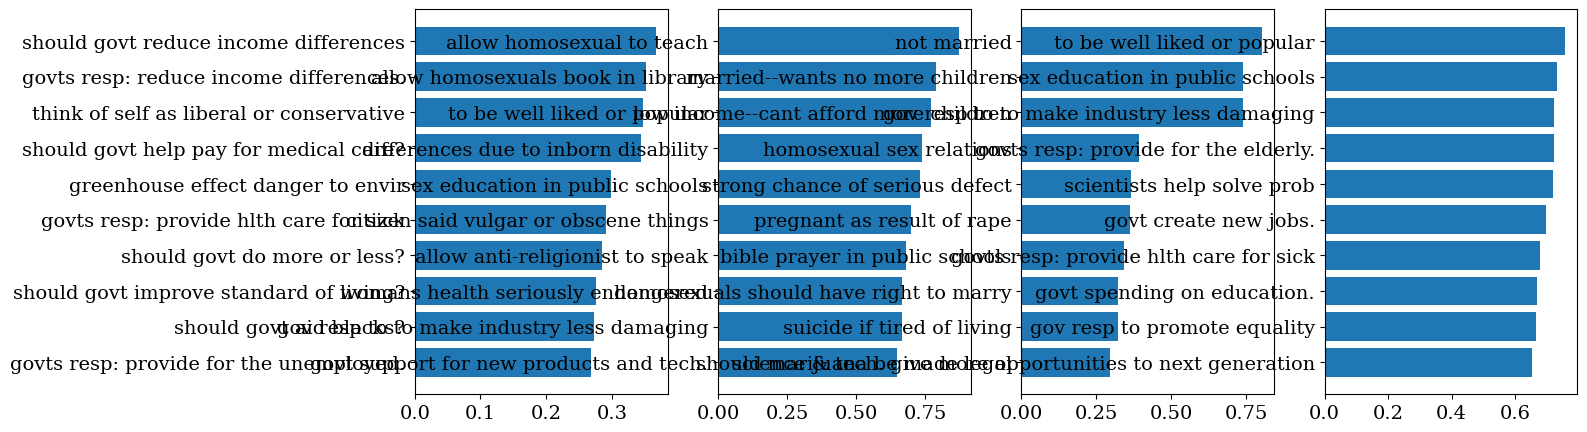

In [31]:
fig, axs = plt.subplots(1,4,figsize=(15,5))

for col, q in enumerate(qs):
    a = pd.DataFrame([*likelihoods[q].items()])

    a['+'] = a[1].apply(lambda x: x['+'])
    a['-'] = a[1].apply(lambda x: x['-'])
    a['Alignment'] = abs(a['+'] - a['-'])
    a = a.drop(columns=1)

    a.columns = ['Q', '+', '-', 'Alignment']
    
    axs[col].barh(a.sort_values('Alignment',ascending=False)[:10]['Q'], a.sort_values('Alignment',ascending=False)[:10]['Alignment'])
    axs[col].invert_yaxis()

#for row_col in [(0,0), (0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3)]:
    

fig.tight_layout()

In [32]:
np.random.choice([*likelihoods.keys()])

'confidence in military'

In [169]:
df_exp.pivot_table(index=['sex education in public schools'],
                columns='abortion if woman wants for any reason', 
                values='gss year for this respondent',
                aggfunc='count')

abortion if woman wants for any reason,-1,1,?
sex education in public schools,,,
-1,61,12,73
1,433,368,921
?,479,457,63


In [172]:
df.pivot_table(index=['sex education in public schools'],
                columns='abortion if woman wants for any reason', 
                values='gss year for this respondent',
                aggfunc='count')

abortion if woman wants for any reason,1,2,n
sex education in public schools,,,
1,6632,8499,14602
2,383,1826,2255
n,7455,10475,10339


In [27]:
{v:k for k,v in meta.column_names_to_labels.items()}['to be well liked or popular']

'popular'

In [29]:
meta.variable_value_labels['popular']

{1: 'most important',
 2: '2nd important',
 3: '3rd important',
 4: '4th important',
 5: 'least important',
 'n': 'NA',
 'd': 'DK',
 'i': 'IAP'}

## Create the Network

In [26]:
def network_out_of_relationships(rel, likelihoods):
    g = nx.Graph()

    for p1, v in rel.items():
        g.add_node(p1)
        for p2, s in v.items():
            if s!=0:
                g.add_edge(p1,p2,weight=abs(likelihoods[p1][p2]['+']-likelihoods[p1][p2]['-']))

    return g

In [35]:
g = network_out_of_relationships(relationships,likelihoods)

In [36]:
len(g.edges)

5444

In [37]:
nx.write_gexf(g, "../data/gss/graph/graph_2016.gexf")

: 

## For loop for years

In [199]:
gamma = .7

for year in [*df['gss year for this respondent'].unique()][22:]:
    print(year)
    df_exp = df[df['gss year for this respondent'] == year].copy()

    nan_columns = []

    for col in df_exp.columns:
        if sum(df_exp[col] == 0) == len(df_exp):
            nan_columns.append(col)

    df_exp = df_exp.drop(columns=nan_columns)

    cols = [*df_exp.columns]

    column_combinations = [*itertools.combinations(cols, 2)]

    cols_w_sign = sorted([f"+{c}" for c in cols] + [f"-{c}" for c in cols], key=lambda x: x[1:])

    association_matrix = pd.DataFrame(columns=cols_w_sign, index=cols_w_sign)
    association_matrix = association_matrix.fillna(0)

    for c1, c2 in column_combinations:
        pos_pos_count = len(df_exp[(df_exp[c1] == 1) & (df_exp[c2] == 1)])
        neg_neg_count = len(df_exp[(df_exp[c1] == -1) & (df_exp[c2] == -1)])
        pos_neg_count = len(df_exp[(df_exp[c1] == 1) & (df_exp[c2] == -1)])
        neg_pos_count = len(df_exp[(df_exp[c1] == -1) & (df_exp[c2] == 1)])
        
        association_matrix[f"+{c1}"][f"+{c2}"] = pos_pos_count
        association_matrix[f"+{c2}"][f"+{c1}"] = pos_pos_count
        
        association_matrix[f"-{c1}"][f"-{c2}"] = neg_neg_count
        association_matrix[f"-{c2}"][f"-{c1}"] = neg_neg_count
        
        association_matrix[f"+{c1}"][f"-{c2}"] = pos_neg_count
        association_matrix[f"-{c2}"][f"+{c1}"] = pos_neg_count

        association_matrix[f"-{c1}"][f"+{c2}"] = neg_pos_count
        association_matrix[f"+{c2}"][f"-{c1}"] = neg_pos_count


    relationships, likelihoods = determine_relationships_likelihoods(association_matrix, gamma)

    g = network_out_of_relationships(relationships)

    nx.write_gexf(g, f"../data/gss/graph/graph_{year}.gexf")

2000


KeyboardInterrupt: 

In [200]:
len(gpt_matching)

349

In [202]:
len(meta.column_labels)

1358

In [194]:
graph_list = sorted(glob.glob('../data/gss/graph/*'))

In [195]:
log = []
density = []

for f in graph_list:
    year = int(f.split('_')[1].split('.')[0])
    g = nx.read_gexf(f)
    sorted_pagerank = sorted([*nx.pagerank(g).items()], key = lambda x: x[1], reverse=True)
    enumerated = {i[0]:o+1 for o, i in enumerate(sorted_pagerank)}
    log.append((year, enumerated['political party affiliation']))
    density.append((year, nx.density(g)))

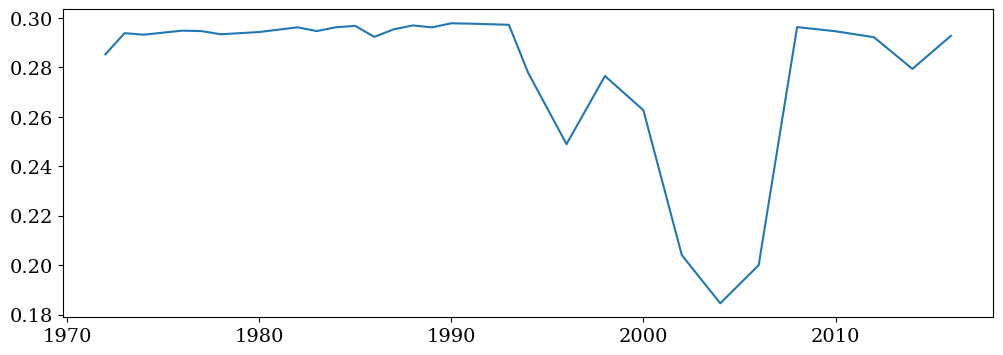

In [196]:
plt.figure(figsize=(12,4))
plt.plot([i[0] for i in density],[i[1] for i in density])

## Alignments Based On Expected Frequencies

In [28]:
def find_relationships_w_contingency_table(df_exp, propositions, pair_combs, significance = .01):
    
    relationships = {p1:{p2:None for p2 in propositions if p1!=p2} for p1 in propositions}

    for q1, q2 in pair_combs:
        table = df_exp[(df_exp[q1]!='?') & (df_exp[q2]!='?')].pivot_table(index=q1, columns=q2, values='gss year for this respondent', aggfunc='count')
        if (table.sum().sum() == 0) or (1 not in [*table.columns]) or (-1 not in [*table.columns]) or (1 not in [*table.index]) or (-1 not in [*table.index]):
            relationships[q1][q2] = 0
            relationships[q2][q1] = 0
        else:
            statistic, pvalue, dof, expected_freq = chi2_contingency(table)
            if pvalue > significance:
                relationships[q1][q2] = 0
                relationships[q2][q1] = 0
            
            else:
                expected_freq = pd.DataFrame(expected_freq, columns=[*table.columns], index = [*table.index])

                rel_strength_observed = (table[1][1] + table[-1][-1])/table.sum().sum() - (table[1][-1] + table[-1][1])/table.sum().sum()
                rel_strength_expected = (expected_freq[1][1] + expected_freq[-1][-1])/table.sum().sum() - (expected_freq[1][-1] + expected_freq[-1][1])/table.sum().sum()

                rel_strength_relative = rel_strength_observed - rel_strength_expected

                relationships[q1][q2] = rel_strength_relative
                relationships[q2][q1] = rel_strength_relative

    return relationships

In [29]:
def network_out_of_relationships(relationships):
    g = nx.Graph()

    for p1, v in relationships.items():
        g.add_node(p1)

        for p2, s in v.items():
            if (s!=0) and (s!=None):
                g.add_edge(p1,p2,weight=abs(relationships[p1][p2]),sign=np.sign(relationships[p1][p2]))

    return g

In [30]:
for year in [*df['gss year for this respondent'].unique()][-1:]:
    print(year)
    
    df_exp = df[df['gss year for this respondent'] == year]
    
    nan_columns = []

    for col in df_exp.columns:
        if (sum(df_exp[col] == 0) == len(df_exp)) | (sum(df_exp[col] == '?') == len(df_exp)) | (sum(df_exp[col] == 1) == len(df_exp)) | (sum(df_exp[col] == -1) == len(df_exp)):
            nan_columns.append(col)

    df_exp = df_exp.drop(columns=nan_columns)

    propositions = [*df_exp.columns][1:]
    pair_combs = [*itertools.combinations(propositions,2)]

    relationships = find_relationships_w_contingency_table(df_exp, propositions, pair_combs, significance = .01)

    g = network_out_of_relationships(relationships)

    nx.write_gexf(g, f"../data/gss/graph/graph_{year}.gexf")

2016


In [42]:
sorted([*relationships['benefits of sci research outweight harmful results'].items()], key= lambda x: abs(x[1]), reverse=True)

[('sci rsch is necessary and should be supported by federal govt',
  0.14087674120030577),
 ('science & tech. give more opportunities to next generation',
  0.13834611017521464),
 ('for or against preferential hiring of women', -0.13699776785714285),
 ('sci research is strongly in favor of benefits', nan),
 ('sci research is strongly in favor of harmful results', nan),
 ('scientists help solve prob', 0.1515187496753223),
 ('scientists work for good of humanity', 0.14034241441494932),
 ('scientists want to make life better for avg person', 0.13270599410756298),
 ('should grown children move back with parents', 0.10628650361094841),
 ('govts resp: provide jobs for all.', -0.10585564279632975),
 ('astrology is scientific', -0.09335134212498791),
 ('benefit of nanotechnology outweigh harmful results', 0.08440136847026694),
 ('allow public meetings protesting govt.', 0.0841840919907671),
 ('balance will be strongly in favor of the benefits or slightly',
  0.08355371900826442),
 ('opinion of

In [12]:
graph_list = sorted(glob.glob('../data/gss/graph/*'))

In [72]:
pagerank_log = []
betweenness_centrality = []
degree_centrality = []

density = []
clustering_coef = []
shortest_path_length = []
diameter = []
cc_count = []

for f in graph_list:
    year = int(f.split('_')[1].split('.')[0])
    g = nx.read_gexf(f)

    # remove nan edges
    for e in [e for e in g.edges if np.isnan(g.edges[e]['weight'])]:
        g.remove_edge(e[0], e[1])

    bc = nx.centrality.betweenness_centrality(g)
    sorted_bc = sorted([*bc.items()], key = lambda x: x[1], reverse=True)
    enumerated = {i[0]:o+1 for o, i in enumerate(sorted_bc)}
    betweenness_centrality.append(enumerated)

    dc = nx.centrality.degree_centrality(g)
    sorted_dc = sorted([*dc.items()], key = lambda x: x[1], reverse=True)
    enumerated = {i[0]:o+1 for o, i in enumerate(sorted_dc)}
    degree_centrality.append(enumerated)

    pagerank = nx.pagerank(g)
    sorted_pagerank = sorted([*pagerank.items()], key = lambda x: x[1], reverse=True)
    enumerated = {i[0]:o+1 for o, i in enumerate(sorted_pagerank)}
    pagerank_log.append(enumerated)

    try:
        shortest_path_length.append((year, nx.average_shortest_path_length(g)))
    except:
        Gcc = sorted(nx.connected_components(g), key=len, reverse=True)
        G0 = g.subgraph(Gcc[0])
        shortest_path_length.append((year, nx.average_shortest_path_length(G0)))
    
    cc_count.append((year, len([*nx.connected_components(g)])))
    clustering_coef.append((year, nx.average_clustering(g)))
    density.append((year, nx.density(g)))

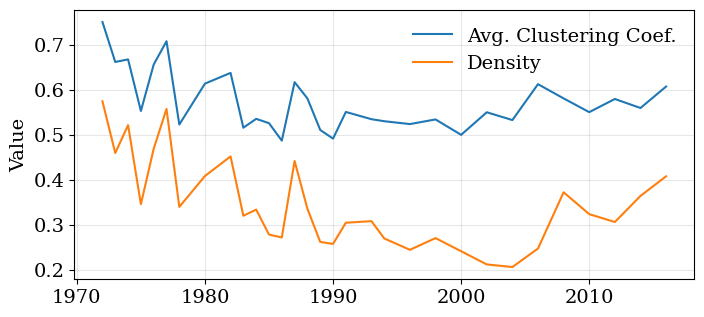

In [122]:
plt.figure(figsize=(8,3.5))
for d, label in zip([clustering_coef, density], ['Avg. Clustering Coef.', 'Density']):
    plt.plot([c[0] for c in d], [c[1] for c in d], label = label)

plt.grid(alpha=.3)
plt.ylabel('Value')
plt.legend(frameon=False)

plt.savefig('../figures/network_level.pdf')

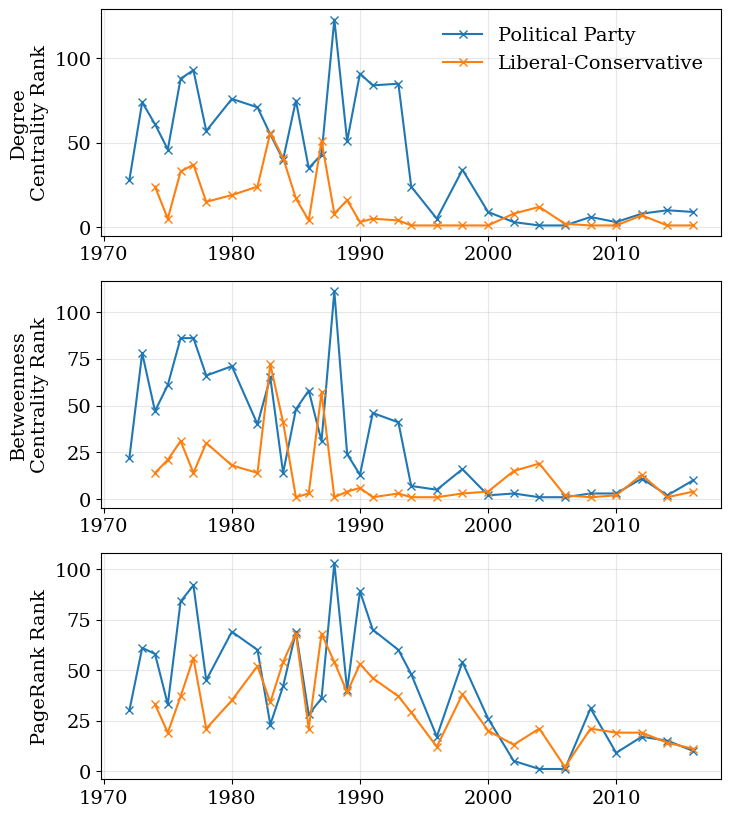

In [84]:
fig, axs = plt.subplots(3, 1, figsize=(8,10))

for row, centrality_measure, ylabel in zip([0,1,2], 
                                    [degree_centrality, betweenness_centrality, pagerank_log], 
                                    ['Degree\nCentrality Rank', 'Betweenness\nCentrality Rank', 'PageRank Rank']):
    for col, label in zip(['political party affiliation', 'think of self as liberal or conservative'], ['Political Party', 'Liberal-Conservative']):
        
        axs[row].plot([int(g.split('_')[1].split('.')[0]) for g in graph_list],
                    [p.get(col) for p in centrality_measure], label=label, marker='x')
        axs[row].grid(alpha=.3)
        axs[row].set_ylabel(ylabel)

axs[0].legend(frameon=False)
fig.show()
fig.savefig('../figures/politic_centrality.pdf')

In [120]:
years = [int(g.split('_')[1].split('.')[0]) for g in graph_list]

for y, c in zip(years, degree_centrality):
    print(y, [f"{i[1]}.{i[0]}" for i in c.items()][0:5])

1972 ['1.allow anti-religionist to teach', '2.allow communist to speak', '3.should women work', '4.allow anti-religionist to speak', '5.allow communists book in library']
1973 ['1.allow homosexual to speak', '2.allow anti-religious book in library', '3.allow communist to speak', '4.allow homosexual to teach', '5.allow homosexuals book in library']
1974 ['1.should communist teacher be fired', '2.allow homosexuals book in library', '3.allow homosexual to speak', '4.allow anti-religious book in library', '5.allow communists book in library']
1975 ['1.should marijuana be made legal', '2.sex education in public schools', '3.favor law against racial intermarriage', '4.birth control information to teens', '5.think of self as liberal or conservative']
1976 ['1.allow anti-religionist to teach', '2.allow homosexual to speak', '3.allow homosexual to teach', '4.allow communist to speak', '5.allow communists book in library']
1977 ['1.allow communist to speak', '2.allow homosexual to teach', '3.all

### Visualization for paper - 2016 Graph

In [16]:
for f in graph_list[-1:]:
    year = int(f.split('_')[1].split('.')[0])
    g = nx.read_gexf(f)

    # remove nan edges
    for e in [e for e in g.edges if np.isnan(g.edges[e]['weight'])]:
        g.remove_edge(e[0], e[1])

In [17]:
nx.write_gexf(g, "../data/gss/graph/graph_2016_vis.gexf")

# Alignments Based on Partial Correlation

In [ ]:
from pingouin import partial_corr

In [152]:
[*df['gss year for this respondent'].unique()][-1:]

[2016]

In [161]:
pagerank_log = []
betweenness_centrality = []
degree_centrality = []

density = []
clustering_coef = []
shortest_path_length = []
diameter = []
cc_count = []

for year in [*df['gss year for this respondent'].unique()]:
    print(year)
    
    df_exp = df[df['gss year for this respondent'] == year]
    
    nan_columns = []

    for col in df_exp.columns:
        if (sum(df_exp[col] == 0) == len(df_exp)) | (sum(df_exp[col] == '?') == len(df_exp)) | (sum(df_exp[col] == 1) == len(df_exp)) | (sum(df_exp[col] == -1) == len(df_exp)):
            nan_columns.append(col)

    df_exp = df_exp.drop(columns=nan_columns)

    df_exp = df_exp.replace('?', 0).copy()
    df_exp = df_exp.drop(columns=['gss year for this respondent'])
    all_variables = [*df_exp.columns]

    partial_correlation_data = []

    for i, x in enumerate(all_variables):
        for y in all_variables[i:]:
            if x != y:
                covariates = list(set(all_variables) - set([x,y]))
                results = partial_corr(data = df_exp, x = x, y = y, covar = covariates)
                
                partial_correlation_data.append((x, y, results['r']['pearson'], results['p-val']['pearson']))

    nx.write_gexf(g, f"../data/gss/graph/graph_{year}.gexf")

    bc = nx.centrality.betweenness_centrality(g)
    sorted_bc = sorted([*bc.items()], key = lambda x: x[1], reverse=True)
    enumerated = {i[0]:o+1 for o, i in enumerate(sorted_bc)}
    betweenness_centrality.append(enumerated)

    dc = nx.centrality.degree_centrality(g)
    sorted_dc = sorted([*dc.items()], key = lambda x: x[1], reverse=True)
    enumerated = {i[0]:o+1 for o, i in enumerate(sorted_dc)}
    degree_centrality.append(enumerated)

    pagerank = nx.pagerank(g)
    sorted_pagerank = sorted([*pagerank.items()], key = lambda x: x[1], reverse=True)
    enumerated = {i[0]:o+1 for o, i in enumerate(sorted_pagerank)}
    pagerank_log.append(enumerated)

    cc_count.append((year, len([*nx.connected_components(g)])))
    clustering_coef.append((year, nx.average_clustering(g)))
    density.append((year, nx.density(g)))

1972
1973
1974
1975
1976
1977
1978
1980
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1993
1994


/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))


1996
1998
2000
2002


/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
/media/volume/data/miniconda3/envs/prosocial/lib/python

2004
2006
2008
2010
2012
2014


/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
/media/volume/data/miniconda3/envs/prosocial/lib/python

2016
